In [254]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import numpy as np
from stompy.plot import plot_wkb
import xarray as xr
import os
from stompy import utils
from stompy.io.local import usgs_nwis
from matplotlib.colors import LogNorm, Normalize
from stompy.model import data_comparison
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
import matplotlib.colors

%matplotlib notebook

In [2]:
cmap=scmap.load_gradient('hot_desaturated.cpt')

In [3]:
try:
    [ds.close() for ds in maps]
except NameError:
    pass

run_dir='../dflowfm/runs/waqsed-201404_v04'
model=dfm.DFlowModel.load(os.path.join(run_dir,"flowfm.mdu"))

In [268]:
def conc_figure(model,time=-1,field='mesh2d_IM1',selector=None,**kw):
    maps=[xr.open_dataset(fn) for fn in model.map_outputs()]

    grids=[unstructured_grid.UnstructuredGrid.read_dfm(ds) for ds in maps]

    fig=plt.figure(figsize=(8,5))
    ax1=fig.add_axes([0.05,0.05,0.65,0.9])
    ax2=fig.add_axes([0.7,0.05,0.25,0.9])

    if selector is None:
        def selector(ds):
            return ds[field].isel(time=time)

    norm=Normalize(vmin=kw.pop('vmin',0),vmax=kw.pop('vmax',40))

    zoom_tot=(601401.4823525589, 633919.6023225272, 4215926.962814284, 4307384.175229818)
    zoom_lindsey=(603872.7383399084, 612792.899006663, 4230569.996306145, 4237493.911339816)
    zoom_csc=(603315.6899263468, 618977.244488898, 4232158.754064366, 4244315.404279252)

    colls=[]
    for g,ds in zip(grids,maps):
        wet=ds.mesh2d_waterdepth.isel(time=time).values > 0.01
        for ax,clip in zip([ax1,ax2],[zoom_csc,zoom_tot]):
            defaults=dict(norm=norm,ax=ax,cmap='jet',mask=wet)
            defaults.update(kw)
            ccoll=g.plot_cells(values=selector(ds),**defaults)
            ccoll.set_edgecolor('face')
            colls.append(ccoll)

    plot_utils.cbar(colls[0],ax=ax2,label=field,extras=colls[1:])
    for ax in [ax1,ax2]:
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)
        ax.axis('equal')

    ax1.axis(zoom_csc)
    ax2.axis(zoom_tot)
    date_str=str(ds.time.values[time])
    step=np.arange(len(ds.time))[time]
    ax1.text(0.02,0.98,"Step %d: %s"%(step,date_str),va='top',
            transform=ax1.transAxes)
    return fig
#conc_figure(models[1])

In [84]:
observed={}
obs_start=np.datetime64("2014-03-15")
obs_end =np.datetime64("2014-05-15")


In [85]:
def proc_usgs(station,products=[63680]):
    ds=usgs_nwis.nwis_dataset(station,
                              products=products,
                              start_date=obs_start,end_date=obs_end,
                              cache_dir='.')
    ds['ssc']=2.2*ds.turbidity
    ds['time'].values[:] += np.timedelta64(-8,'h') # PST.  
    return ds

observed['FPX']=proc_usgs(11447650,products=[63680,63680])
observed['LIB']=proc_usgs(11455315,products=[63680,63680,65])
observed['VRO']=proc_usgs(11425500)
observed['SRV']=proc_usgs(11455420,products=[63680,65])
observed['HST']=proc_usgs(11455280) # Cache near Hastings.  Just added as obs point
observed['LibCutHolland']=proc_usgs(11455146) # Liberty at Little Holland
observed['DWSCTL']=proc_usgs(11455142) # new point.partial record, 2014-04-12 onwards
observed['HBW']=proc_usgs(11455165) # Miner slough, two instruments.
observed['SDC']=proc_usgs(11447890) # yep.

INFO:usgs_nwis:Cached   2014-03-01 00:00:00 -- 2014-04-01 00:00:00
INFO:usgs_nwis:Cached   2014-04-01 00:00:00 -- 2014-05-01 00:00:00
INFO:usgs_nwis:Cached   2014-05-01 00:00:00 -- 2014-06-01 00:00:00
INFO:usgs_nwis:Cached   2014-03-01 00:00:00 -- 2014-04-01 00:00:00
INFO:usgs_nwis:Cached   2014-04-01 00:00:00 -- 2014-05-01 00:00:00
INFO:usgs_nwis:Cached   2014-05-01 00:00:00 -- 2014-06-01 00:00:00
INFO:usgs_nwis:Fetching 11425500_63680_2014-03-01_2014-04-01.nc
INFO:usgs_nwis:Fetching 11425500_63680_2014-04-01_2014-05-01.nc
INFO:usgs_nwis:Fetching 11425500_63680_2014-05-01_2014-06-01.nc
INFO:usgs_nwis:Cached   2014-03-01 00:00:00 -- 2014-04-01 00:00:00
INFO:usgs_nwis:Cached   2014-04-01 00:00:00 -- 2014-05-01 00:00:00
INFO:usgs_nwis:Cached   2014-05-01 00:00:00 -- 2014-06-01 00:00:00
INFO:usgs_nwis:Fetching 11455280_63680_2014-03-01_2014-04-01.nc
INFO:usgs_nwis:Fetching 11455280_63680_2014-04-01_2014-05-01.nc
INFO:usgs_nwis:Fetching 11455280_63680_2014-05-01_2014-06-01.nc
INFO:usgs_nwi

In [86]:
observed.keys()

dict_keys(['FPX', 'LIB', 'VRO', 'SRV', 'HST', 'LibCutHolland', 'DWSCTL', 'HBW', 'SDC'])

In [12]:
def station_location_map(ax_map,station):
    plot_wkb.plot_wkb(poly,fc='0.7',ax=ax_map)
    ax_map.plot([ dss[0].station_x_coordinate],
                [ dss[0].station_y_coordinate],'ro')
    ax_map.axis('equal')
    ax_map.xaxis.set_visible(0)
    ax_map.yaxis.set_visible(0)

In [259]:
import six
six.moves.reload_module(utils)
six.moves.reload_module(data_comparison)

<module 'stompy.model.data_comparison' from '/home/rusty/src/stompy/stompy/model/data_comparison.py'>

In [257]:
# Compare some time series
models=[]
# model_v01=dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v01/flowfm.mdu")
#model_v02=dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v02/flowfm.mdu")
#model_v03=dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v03/flowfm.mdu")
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v04/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v05/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v06/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v07/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v08/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v09/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v10/flowfm.mdu") )
#models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v11/flowfm.mdu") )
models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v12/flowfm.mdu") )
models.append( dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v13/flowfm.mdu") )



try:
    poly
except NameError:
    poly=models[0].grid.boundary_polygon()

<IPython.core.display.Javascript object>


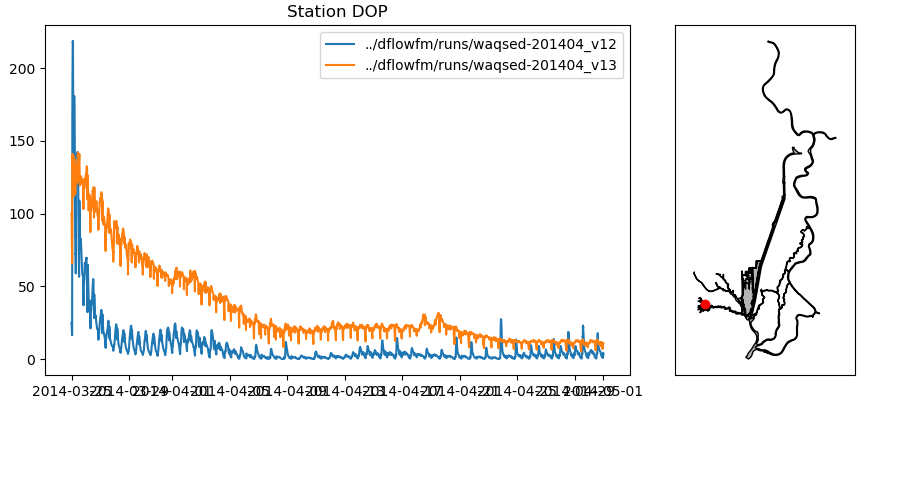

<IPython.core.display.Javascript object>


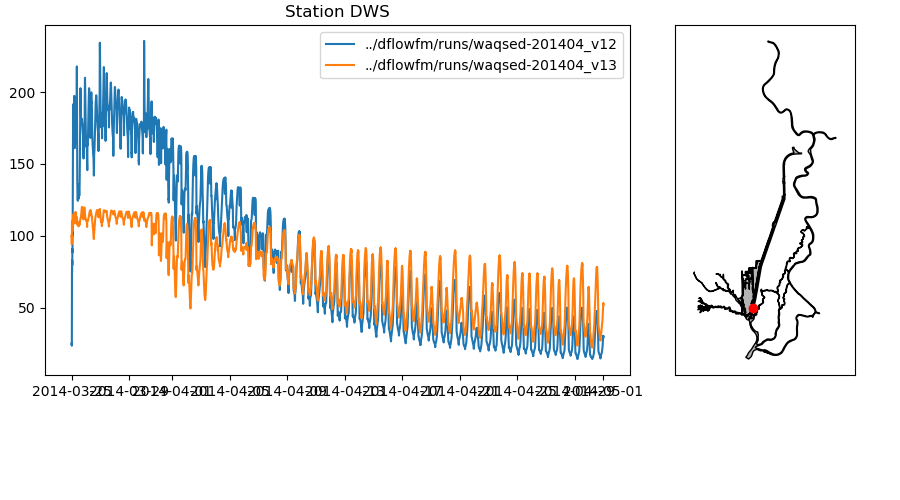

<IPython.core.display.Javascript object>


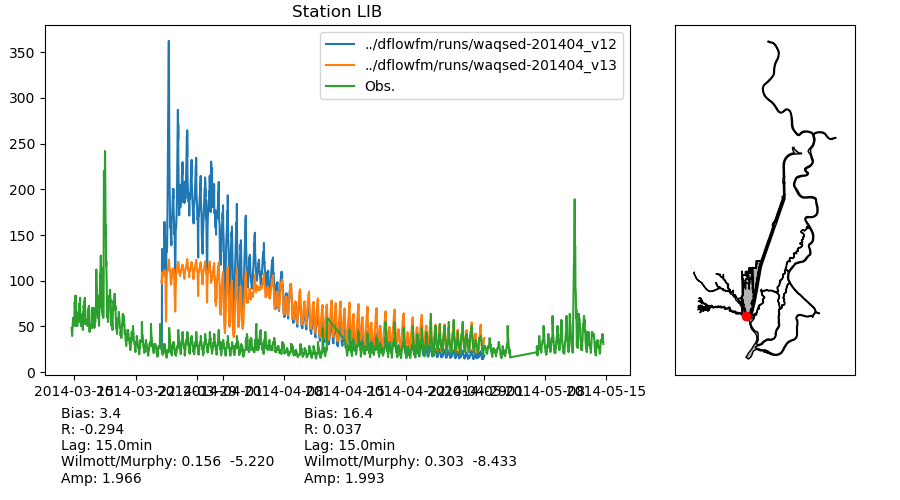

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/anaconda3/lib/python

<IPython.core.display.Javascript object>


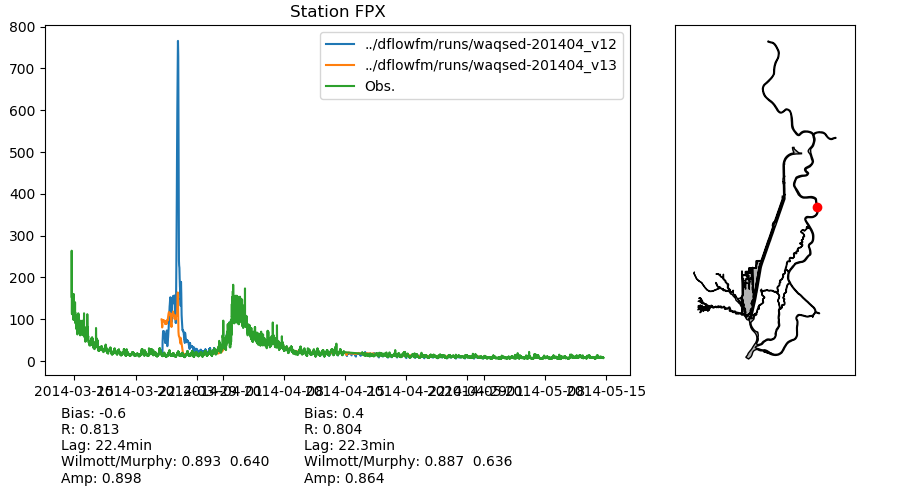

<IPython.core.display.Javascript object>


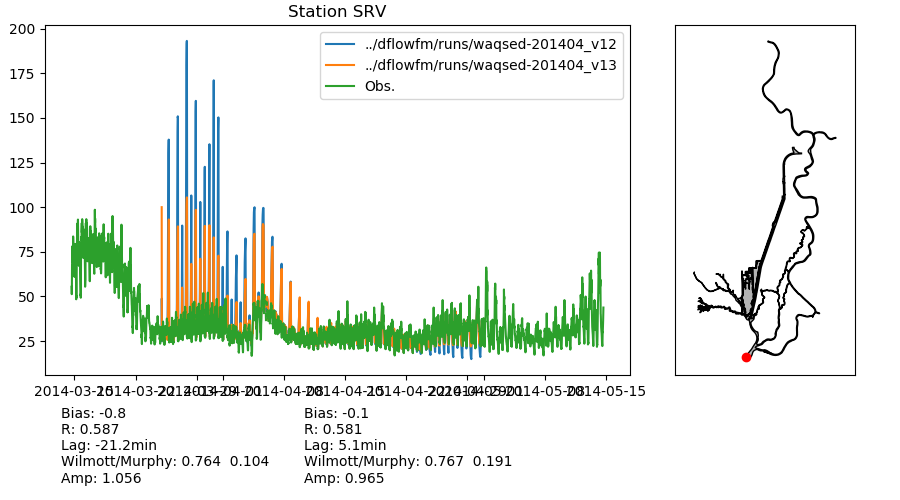

<IPython.core.display.Javascript object>


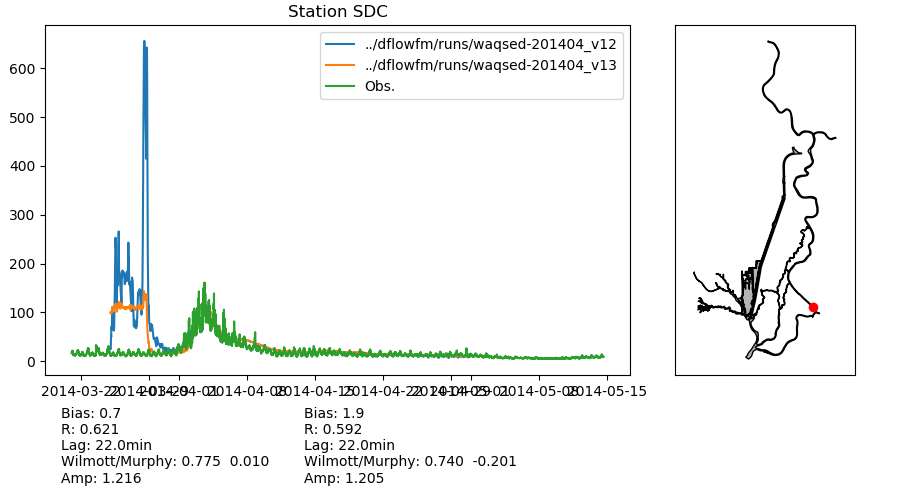

<IPython.core.display.Javascript object>


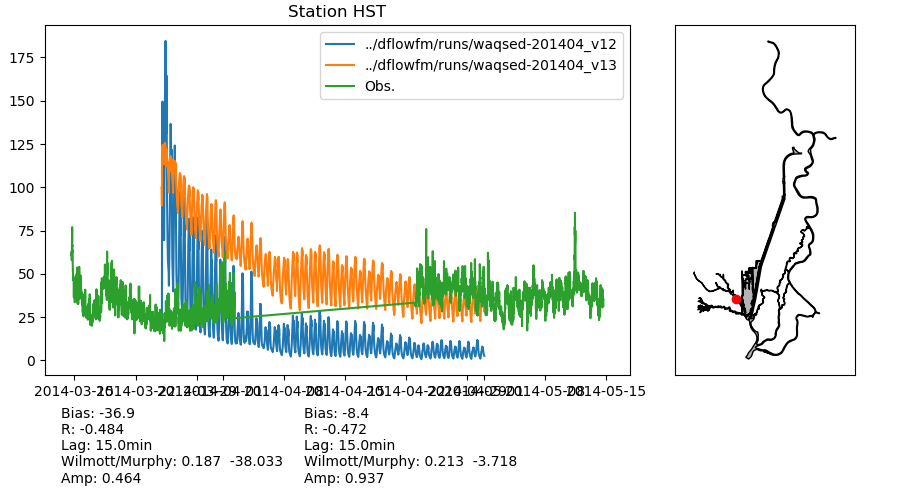

<IPython.core.display.Javascript object>


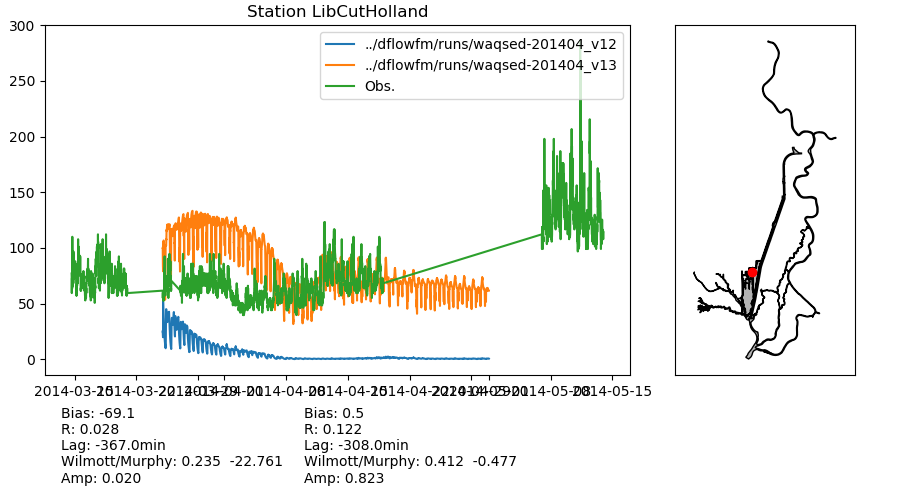

<IPython.core.display.Javascript object>


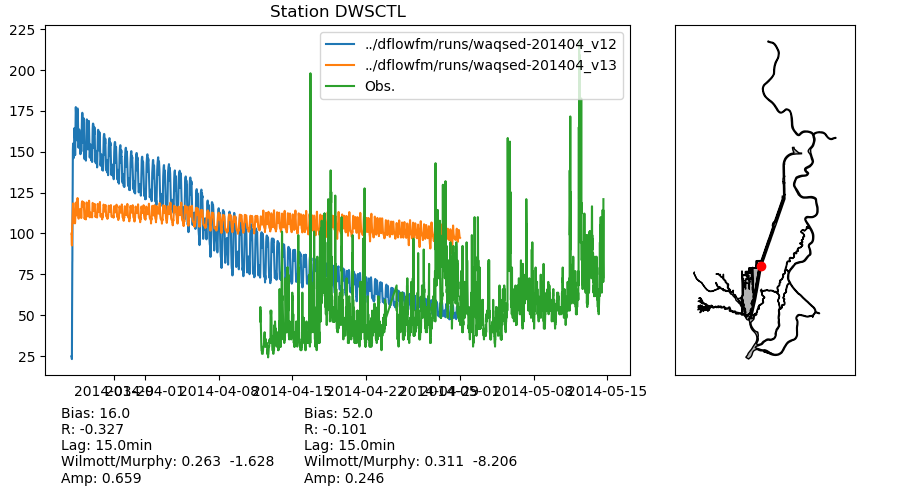

<IPython.core.display.Javascript object>


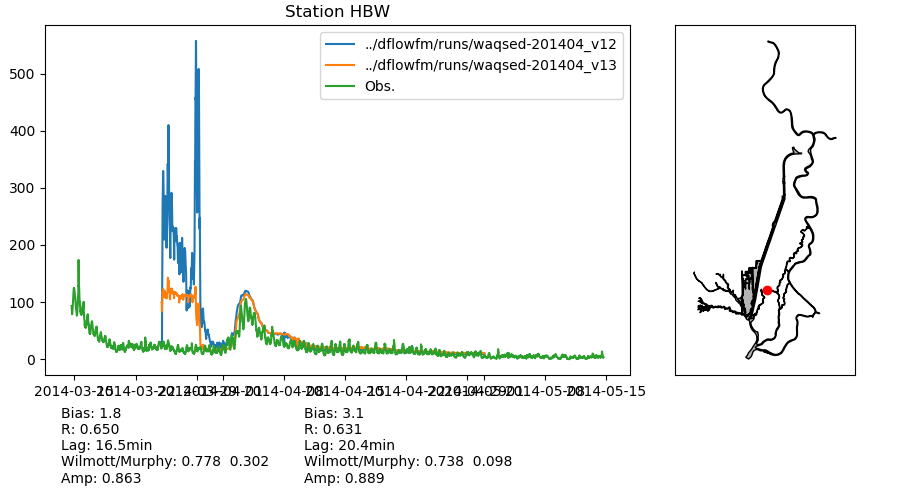

In [260]:
plt.close('all')
# What are some good stations?
stations=['DOP','DWS','LIB','FPX','SRV','SDC','HST','LibCutHolland','DWSCTL',
          'HBW']

for station in stations:
    dss=[]
    for model in models:
        ds=model.extract_station(name=station,refresh=station==stations[0])
        if ds is None:
            continue
        ds.attrs['label']=model.run_dir
        dss.append(ds)
    if not dss:
        print("No models have %s"%station)
        continue
    fig=plt.figure(figsize=(9,5))
    y=0.25
    ax=fig.add_axes([0.05,y,0.65,0.95-y])
    ax_map=fig.add_axes([0.75,y,0.2,0.95-y])
    ax_txt=fig.add_axes([0.05,0.02,0.9,y-0.08])
    for ds,model in zip(dss,models):
        ax.plot(ds.time.values,ds.IM1.values,label=ds.label)
        
    if station in observed:
        obs=observed[station]
        ax.plot(obs.time,obs.ssc,label='Obs.')
    ax.legend(loc='upper right')
    ax.set_title(f"Station {station}")
    station_location_map(ax_map,dss[0])
    
    if 1:
        ax_txt.xaxis.set_visible(0)
        ax_txt.yaxis.set_visible(0)
        plt.setp(ax_txt.spines.values(),visible=0)
        if station in observed:
            obs=observed[station].ssc
            mods=[ds.IM1.isel(time=ds.time.values>ds.time.values[0]+np.timedelta64(15,'D'))
                  for ds in dss]
            combined=data_comparison.combine_sources([obs]+mods)
            if combined is not None:
                for i in range(len(mods)):
                    metrics=data_comparison.calc_metrics(combined.isel(source=i+1),
                                                         combined.isel(source=0))
                    txt="\n".join( ["Bias: %.1f"%metrics['bias'],
                                    "R: %.3f"%metrics['r'],
                                    "Lag: %.1fmin"%(metrics['lag_s']/60.),
                                    "Wilmott/Murphy: %.3f  %.3f"%(metrics['wilmott'],
                                                                  metrics['murphy']),
                                    "Amp: %.3f"%metrics['amp']])
                    ax_txt.text(0.02+i*0.3,0.98,txt,va='top')
                  

<IPython.core.display.Javascript object>


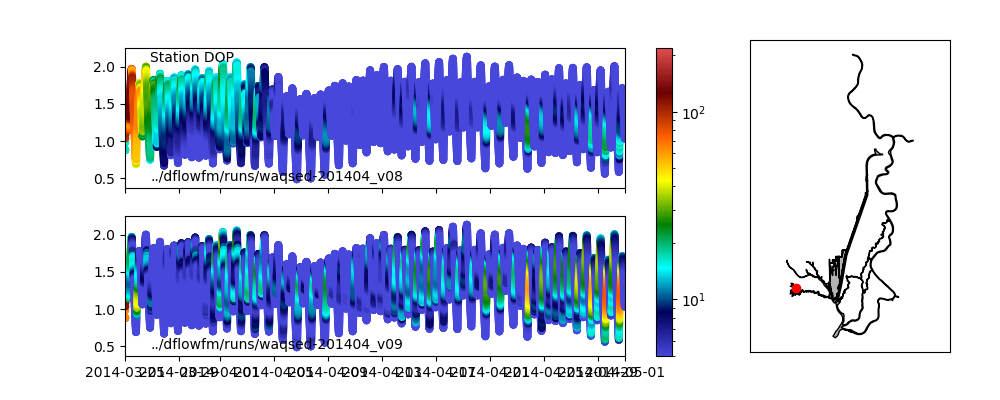

<IPython.core.display.Javascript object>


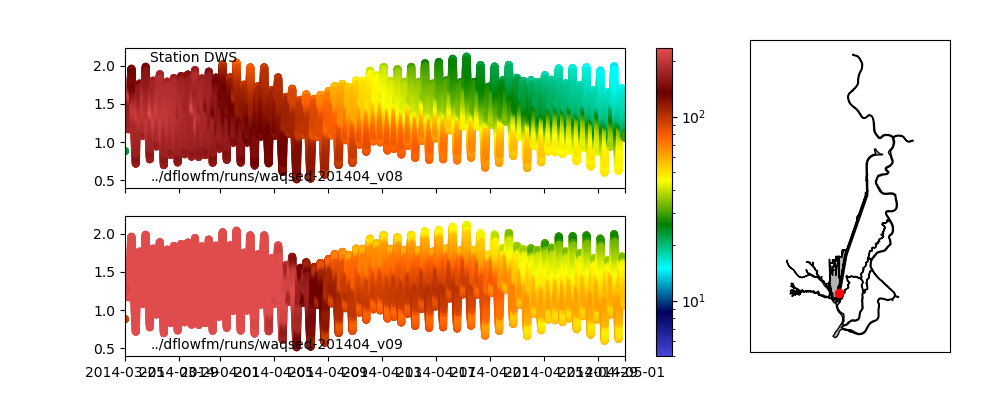

<IPython.core.display.Javascript object>


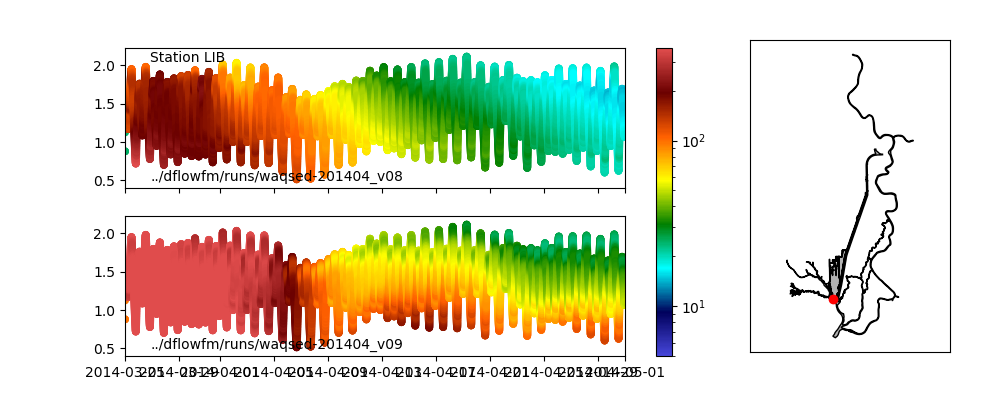

<IPython.core.display.Javascript object>


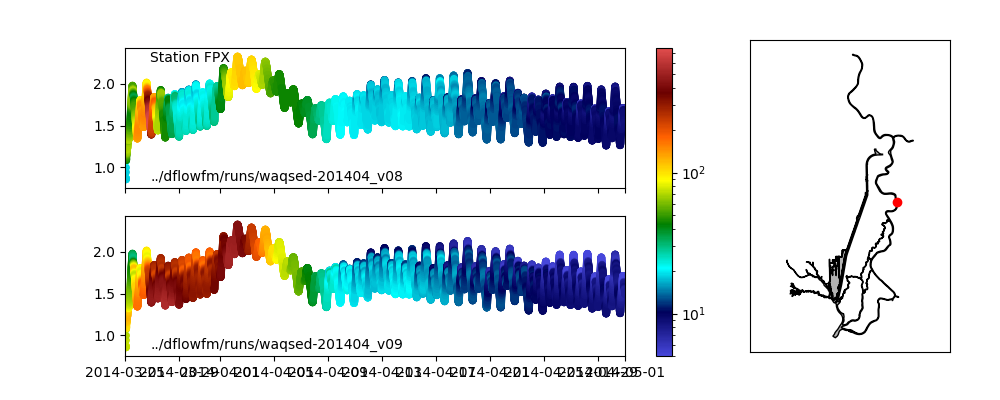

<IPython.core.display.Javascript object>


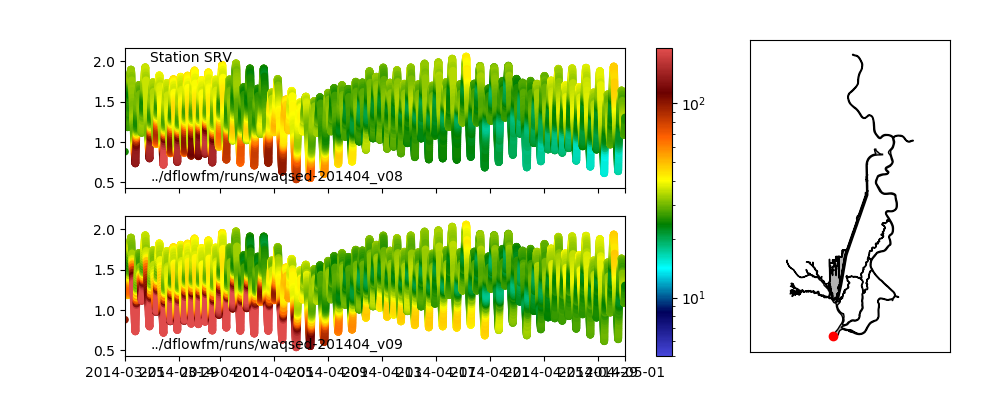

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


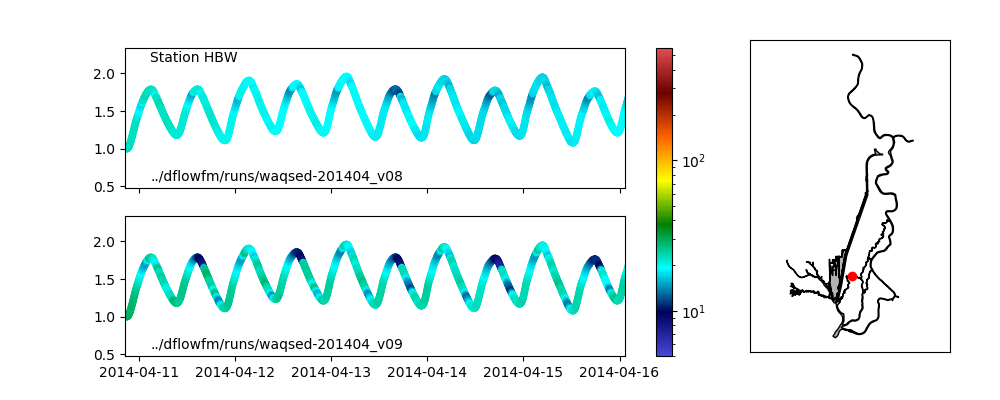

In [104]:
# LIB SSC phase is entirely wrong.  No stage during this period
# at LIB.
# SRV phase is exact. (it's the BC)


# Tidal phase plots from the model:

# What are some good stations?
stations=['DOP','DWS','LIB','FPX','SRV','HBW']

for station in stations:
    dss=[model.extract_station(name=station) for model in models]
    fig,axs=plt.subplots(len(dss),1,figsize=(10,4),sharex=True,sharey=True)
    fig.subplots_adjust(right=0.75)
    ax_map=fig.add_axes([0.75,0.12,0.2,0.78])

    norm=LogNorm(vmin=5.0)
    scats=[]
    for ax,ds,model in zip(axs,dss,models):
        scat=ax.scatter(ds.time.values,
                        ds.waterlevel.values,20,
                        ds.IM1.values,label=model.run_dir,
                        cmap=cmap,norm=norm)
        scats.append(scat)
        ax.text(0.05,0.05,model.run_dir,transform=ax.transAxes)
        
    plt.colorbar(scats[0],ax=axs)
    axs[0].text(0.05,0.98,f"Station {station}",va='top',transform=axs[0].transAxes)
    station_location_map(ax_map,dss[0])
    axs[0].axis(xmin=ds.time.values[0],xmax=ds.time.values[-1])

In [ ]:
# Compare Verona and FPT to adjust concentration and timing between them.
plt.figure()
vro=observed['VRO']
fpt=observed['FPX']

plt.plot(vro.time.values,vro.ssc,label='VRO')
plt.plot(fpt.time.values,fpt.ssc,label='FPT')
plt.legend()

In [17]:
# grab some 2015 data for these if possible, get more lag info
# of course.  this time FPT is missing most of the pulse.
start=np.datetime64("2014-01-01")
stop=np.datetime64("2014-06-01")

ds=usgs_nwis.nwis_dataset(11425500,
                            products=[63680,65],
                            start_date=start,end_date=stop,
                            cache_dir='.')
ds['ssc']=2.2*ds.turbidity
ds['time'].values[:] += np.timedelta64(-8,'h') # PST.  
vro=ds

ds=usgs_nwis.nwis_dataset(11447650,
                        products=[63680,65],
                        start_date=start,end_date=stop,
                        cache_dir='.')
ds['ssc']=2.2*ds.turbidity
ds['time'].values[:] += np.timedelta64(-8,'h') # PST.  
fpt=ds

# And CDEC VON
from stompy.io.local import cdec
ds=cdec.cdec_dataset('VON',start_date=start,end_date=stop,
                     sensor=27,cache_dir='.')
ds['time'].values[:] += np.timedelta64(-8,'h')
ds['turb_ntu']=ds['sensor0027']
ds['ssc']=2.2*ds['turb_ntu']
von=ds

INFO:usgs_nwis:Cached   2014-01-01 00:00:00 -- 2014-02-01 00:00:00
INFO:usgs_nwis:Cached   2014-02-01 00:00:00 -- 2014-03-01 00:00:00
INFO:usgs_nwis:Cached   2014-03-01 00:00:00 -- 2014-04-01 00:00:00
INFO:usgs_nwis:Cached   2014-04-01 00:00:00 -- 2014-05-01 00:00:00
INFO:usgs_nwis:Cached   2014-05-01 00:00:00 -- 2014-06-01 00:00:00
INFO:usgs_nwis:Cached   2014-06-01 00:00:00 -- 2014-07-01 00:00:00
INFO:usgs_nwis:Cached   2014-01-01 00:00:00 -- 2014-02-01 00:00:00
INFO:usgs_nwis:Cached   2014-02-01 00:00:00 -- 2014-03-01 00:00:00
INFO:usgs_nwis:Cached   2014-03-01 00:00:00 -- 2014-04-01 00:00:00
INFO:usgs_nwis:Cached   2014-04-01 00:00:00 -- 2014-05-01 00:00:00
INFO:usgs_nwis:Cached   2014-05-01 00:00:00 -- 2014-06-01 00:00:00
INFO:usgs_nwis:Cached   2014-06-01 00:00:00 -- 2014-07-01 00:00:00
INFO:cdec:Cached   2014-01-01 00:00:00 -- 2014-02-01 00:00:00
INFO:cdec:Cached   2014-02-01 00:00:00 -- 2014-03-01 00:00:00
INFO:cdec:Cached   2014-03-01 00:00:00 -- 2014-04-01 00:00:00
INFO:cdec:

In [111]:
# Other USGS stations that aren't good for this period

# 11455385 nope. 
# 11455350 nope (skips over 2014)
# 381424121405601 - nope.  recent.
# 381504121404001 - nope. recent.
# 11455268 - nope, more recent.
# 11455276 - nope, only more recent.
# 11455335 - nope, more recent.
# 11447850, nope, no turb.
# 11447830 - only later 2014 - 2016
# 11447905 - only later
# 11447903 - before and after, but no.
# 11336600 - DCC yes, but it's closed during this time.


In [147]:
tau80=np.percentile(ds.mesh2d_taus.isel(time=slice(200,None)).values,80,axis=0)

E=4320 # g/m2/day
wsettle=21.6 # m/day
C0=25 # g/m3
D=wsettle*C0 # g/m2/day


tau=ds.mesh2d_taus.isel(time=slice(200,None))

tau_n=tau[:,100]

In [157]:
# An example cell
tau_crit=0.79 # iterated to this manually
(tau_n.values/tau_crit - 1).clip(0,np.inf).mean(), D/E # == D/E

(0.1256494354659042, 0.125)

In [162]:
# (tau_n.values/tau_crit - 1).clip(0,np.inf).mean() = D/E
# (tau_n.values/tau_crit - 1).clip(0,np.inf).mean() = D/E

# (tau_n.values - tau_crit).clip(0,np.inf).mean() = tau_crit * D/E
# tau_n.clip(tau_crit,np.inf).mean() = tau_crit * (1 + D/E)

# tau_ns=np.sort(tau_n)

# maybe there is a clever way, but just brute force right now.
from scipy.optimize import fmin
def tau_to_tau_crit(taus,target):
    def cost(tc):
        res=(taus/tc - 1).clip(0,np.inf).mean() - target
        return res**2
    return fmin(cost,0.1,disp=0,xtol=0.001)
tau_to_tau_crit(tau_n.values,D/E) # => 0.791.  good

tau_crits=[ tau_to_tau_crit(tau[:,i],D/E)
           for i in range(tau.shape[1]) ]


In [206]:
# discretized fast version:
def fast_tau_to_tau_crit(taus,target):
    taus=-np.sort(-taus.clip(0.001,np.inf))

    s=np.cumsum(taus)/taus - np.arange(len(taus)) - len(taus)*target
    k=np.searchsorted(s,0).clip(0,len(taus)-1)
    return taus[k]

#taus[60] # k should be between 59 and 60.
#k=60
#taus[:k].sum() / taus[k], len(taus)*(1+target) # 90.8 vs. 275.
#(taus[:k]/taus[k] - 1 ).mean() * k/len(taus), target # good - 0.1259 vs 0.125
#(taus[:k]/taus[k] - 1 ).sum()/len(taus), target # good - 0.1259 vs 0.125
#(taus[:k] - taus[k]).sum()/taus[k], len(taus)*target # good 30.84 vs 30.62
#taus[:k].sum()/taus[k] - k*taus[k]/taus[k], len(taus)*target
#taus[:k].sum()/taus[k] - k, len(taus)*target

#taus=tau[:,100]
#target=D/E
#%timeit fast_tau_to_tau_crit(taus,target) # 142us
#%timeit tau_to_tau_crit(taus,target) # 13.2ms

In [207]:
tau_crits_fast=[ fast_tau_to_tau_crit(tau[:,i],D/E)
                 for i in range(tau.shape[1]) ]


In [213]:
# Compile from each processor:
xyts=[]
for fn in models[-1].map_outputs():
    print(fn)
    ds=xr.open_dataset(fn)
    tau=ds.mesh2d_taus.isel(time=slice(200,None))
    tau_crits=[ fast_tau_to_tau_crit(tau[:,i],D/E)
                for i in range(tau.shape[1]) ]
    xyt=np.c_[ ds.mesh2d_face_x.values,
               ds.mesh2d_face_y.values,
               tau_crits ]
    xyts.append(xyt)
xyt=np.concatenate(xyts)
np.savetxt("tau_crit.xyt",xyt)

../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0000_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0001_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0002_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0003_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0004_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0005_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0006_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0007_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0008_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0009_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0010_map.nc
../dflowfm/runs/waqsed-201404_v12/DFM_OUTPUT_flowfm/flowfm_0011_map.nc


<IPython.core.display.Javascript object>


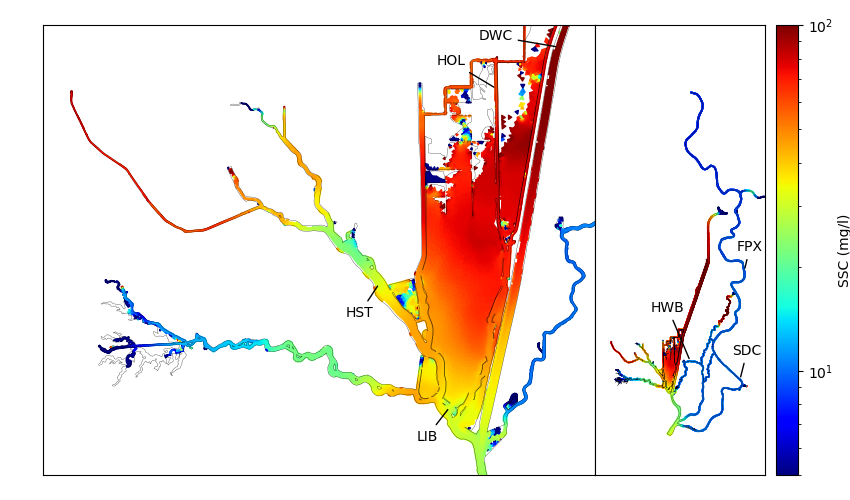

In [284]:
# Make a quick plot to show in report
#mod=dfm.DFlowModel.load("../dflowfm/runs/waqsed-201404_v08/flowfm.mdu")
mod=models[-1]
#fig=conc_figure(mod,field='mesh2d_IM1',time=-1,norm=LogNorm(vmin=5,vmax=100),
#                selector=lambda ds: ds['mesh2d_IM1'].isel(time=slice(-4,None)).mean(dim='time').values )
fig=conc_figure(mod,field='mesh2d_IM1',time=-2,norm=LogNorm(vmin=5,vmax=100))

In [285]:
fig.axes[0].texts[0].set_text("2014-05-01")
fig.axes[2].yaxis.label.set_text('SSC (mg/l)')
fig.set_size_inches([8.5,5],forward=True)
for ax in fig.axes[:2]:
    plot_wkb.plot_wkb(poly,ec='k',lw=0.2,fc='none',ax=ax)

In [332]:
fig.axes[0].texts=[]
fig.axes[1].texts=[]

def add_stn(name,label=None,offset=None):
    label=label or name
    ds=model.extract_station(name=name)
    for ax in fig.axes[:2:]:
        bnd=ax.axis()
        xy=ds.station_x_coordinate.item(),ds.station_y_coordinate.item()
        if offset:
            xy_text=np.array(xy)+np.array(offset)
            ap=dict(arrowstyle='-')
        else:
            xy_text=None
            ap={}
        if utils.within_2d(xy,bnd):
            ax.annotate(label,xy,xytext=xy_text,arrowprops=ap)
            break
    
add_stn('FPX',offset=[-1500,4000])
add_stn('LIB',offset=[-1000,-1000])
add_stn('SDC',offset=[-1500,5000])
add_stn('HST',offset=[-1000,-1000])
add_stn('DWSCTL',label='DWC',offset=[-2400,200])
add_stn('HBW',label='HWB',offset=[-8000,10000])
add_stn('LibCutHolland',label='HOL',offset=[-1800,700])

In [333]:
fig.savefig('ssc-snapshot-labeled.png',dpi=200)

A preliminary water quality model, simulating sediment transport dynamics, has been developed.  This model simulates one sediment tracer and includes deposition, resuspension, a fluff layer, and inputs from Ulatis Creek, Campbell Lake, Lisbon Weir and the Sacramento River.  Development and calibration of this model is ongoing, and 